### Import Liabraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

### Load Dataset

In [2]:
df=pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3525126,259,PAYMENT,598.70,C1270131838,0.0,0.0,M345554882,0.00,0.0,0,0
5927405,404,PAYMENT,12784.49,C751730924,0.0,0.0,M1369454737,0.00,0.0,0,0
3428644,256,CASH_OUT,339224.24,C1035617615,206011.0,0.0,C1095328111,99051.96,438276.2,0,0
1741126,161,PAYMENT,28737.45,C464157268,0.0,0.0,M1707951111,0.00,0.0,0,0
1913765,166,PAYMENT,20084.33,C849735487,0.0,0.0,M852609207,0.00,0.0,0,0


### EDA

In [4]:
df.shape

(6362620, 11)

In [5]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [6]:
# remove impossible observations
((df['type'].isin(['PAYMENT','CASH_OUT','TRANSFER','DEBIT'])) & (df['amount'] > df['oldbalanceOrg'])).sum()

3601544

In [7]:
impossible_observations = ((df['type'].isin(['PAYMENT','CASH_OUT','TRANSFER','DEBIT'])) & (df['amount'] > df['oldbalanceOrg']))

In [8]:
df = df[~((df['type'].isin(['PAYMENT','CASH_OUT','TRANSFER','DEBIT'])) & (df['amount'] > df['oldbalanceOrg']))]

In [10]:
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4364747,310,CASH_IN,132857.94,C883481258,80862.00,213719.94,C1011210176,4031967.63,3899109.69,0,0
1322747,136,PAYMENT,11930.60,C1804020556,55553.00,43622.40,M560454821,0.00,0.00,0,0
761095,38,PAYMENT,32925.26,C617576262,159927.65,127002.39,M1861106941,0.00,0.00,0,0
4121883,302,CASH_IN,172970.69,C57607508,109.00,173079.69,C1485470519,0.00,0.00,0,0
5369049,376,PAYMENT,29681.40,C1568222793,394299.17,364617.78,M1546995519,0.00,0.00,0,0


In [12]:
df.shape

(2761076, 11)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2761076 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 252.8+ MB


In [14]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,2.761076e+06,2.761076e+06,2.761076e+06,2.761076e+06,2.761076e+06,2.761076e+06,2.761076e+06,2.761076e+06
mean,2.428832e+02,1.034841e+05,1.902767e+06,1.970523e+06,9.385120e+05,8.906475e+05,2.964062e-03,5.794842e-06
std,1.446430e+02,1.935515e+05,4.147579e+06,4.183875e+06,2.967796e+06,2.961877e+06,5.436246e-02,2.407241e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.550000e+02,9.187920e+03,3.149500e+04,4.996210e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.370000e+02,4.306981e+04,1.375159e+05,2.064719e+05,5.931265e+04,1.829767e+04,0.000000e+00,0.000000e+00
75%,3.350000e+02,1.591983e+05,1.344458e+06,1.484773e+06,7.529296e+05,6.421338e+05,0.000000e+00,0.000000e+00
max,7.430000e+02,1.000000e+07,5.958504e+07,4.958504e+07,3.555534e+08,3.553814e+08,1.000000e+00,1.000000e+00


In [15]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [16]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

<Axes: xlabel='type'>

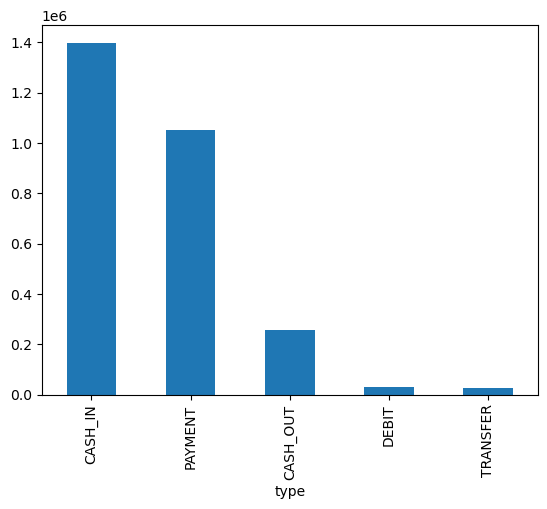

In [17]:
# transaction type distribution
df['type'].value_counts().plot(kind='bar')

<Axes: xlabel='isFraud', ylabel='count'>

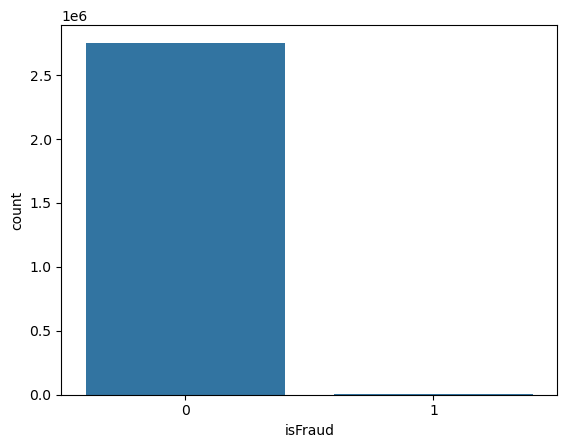

In [18]:
# class ditribution
sns.countplot(x=df['isFraud'])

In [19]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    2761060
1         16
Name: count, dtype: int64

<Axes: xlabel='isFlaggedFraud', ylabel='count'>

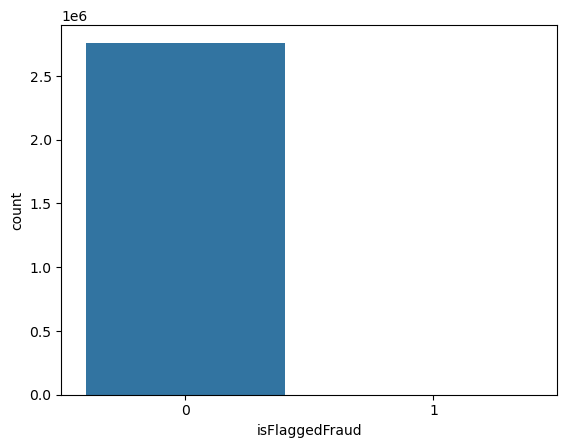

In [20]:
sns.countplot(data=df,x='isFlaggedFraud')

In [21]:
df[df['isFlaggedFraud']==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


<Axes: xlabel='amount', ylabel='Count'>

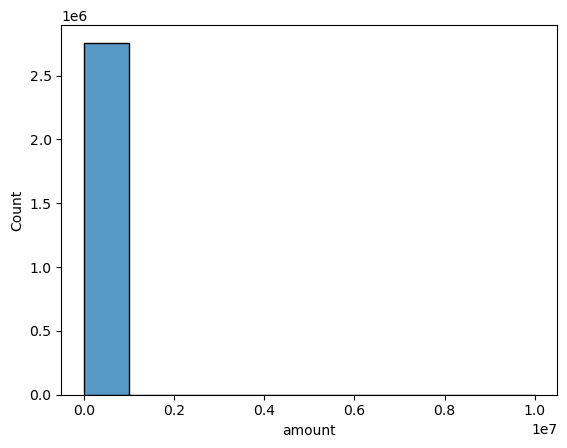

In [31]:
sns.histplot(df['amount'],bins=10)

<Axes: xlabel='newbalanceDest', ylabel='Count'>

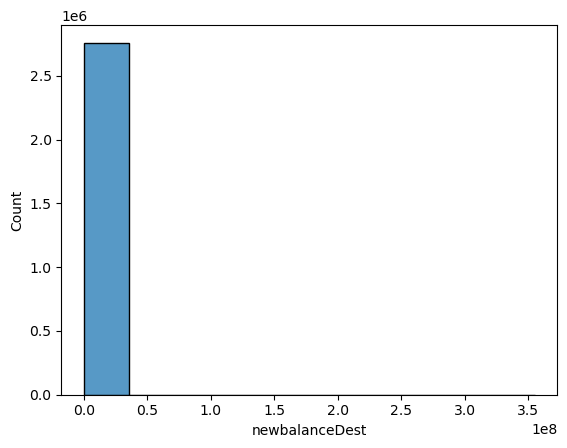

In [32]:
sns.histplot(df['newbalanceDest'],bins=10)

<Axes: xlabel='oldbalanceDest', ylabel='Count'>

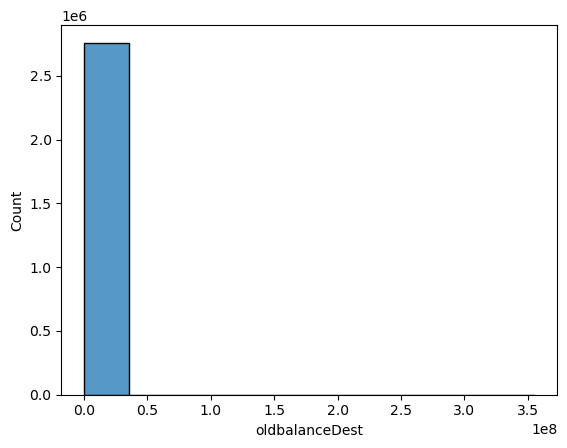

In [30]:
sns.histplot(df['oldbalanceDest'],bins=10)

<Axes: xlabel='oldbalanceOrg', ylabel='Count'>

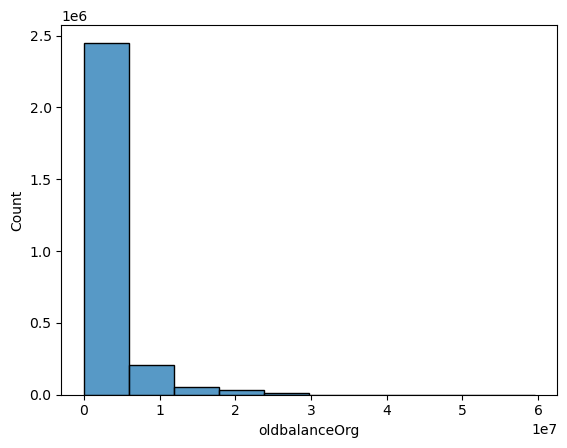

In [28]:
sns.histplot(df['oldbalanceOrg'],bins=10)

<Axes: xlabel='newbalanceOrig', ylabel='Count'>

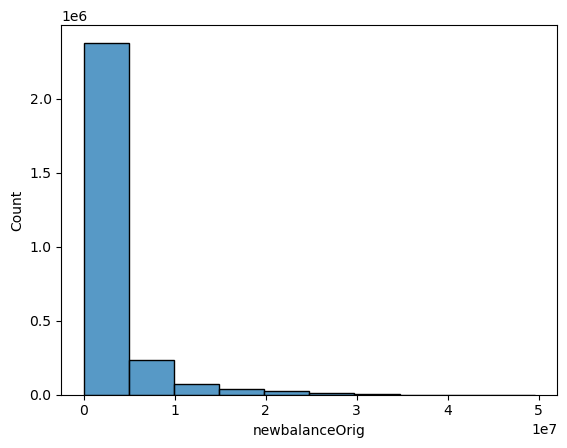

In [29]:
sns.histplot(df['newbalanceOrig'],bins=10)

### Separate target and independent columns

In [33]:
df_encoded = pd.get_dummies(df.drop(columns=['step','nameOrig','nameDest','isFraud']),columns=['type'],drop_first=True,dtype='int64')

In [34]:
X=df_encoded
y=df['isFraud']

In [35]:
# train-test-split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [36]:
# SMOTE balancing
sm=SMOTE(random_state=42)
X_res,y_res=sm.fit_resample(X_train,y_train)

c:\Users\kanha\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [37]:
print('before smote:',np.bincount(y_train))
print('after smote:',np.bincount(y_res))

before smote: [1926989    5764]
after smote: [1926989 1926989]


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score

# XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_res, y_res)
y_pred = xgb.predict(X_test)

c:\Users\kanha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:08:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [40]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test,y_pred))
print('accuracy score', accuracy_score(y_test,y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    825903
           1       0.85      1.00      0.92      2420

    accuracy                           1.00    828323
   macro avg       0.93      1.00      0.96    828323
weighted avg       1.00      1.00      1.00    828323

AUC-ROC: 0.9987114642052246
accuracy score 0.9994845006114764


In [43]:
# Decision tree  model
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
xgb.fit(X_res, y_res)
y_pred1 = xgb.predict(X_test)

c:\Users\kanha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [44]:
print("Classification Report:")
print(classification_report(y_test, y_pred1))
print("AUC-ROC:", roc_auc_score(y_test,y_pred1))
print('accuracy score', accuracy_score(y_test,y_pred1))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    825903
           1       0.85      1.00      0.92      2420

    accuracy                           1.00    828323
   macro avg       0.93      1.00      0.96    828323
weighted avg       1.00      1.00      1.00    828323

AUC-ROC: 0.9987114642052246
accuracy score 0.9994845006114764


In [45]:
# both models perform thge same

In [46]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

pipeline.fit(X_res,y_res)

c:\Users\kanha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:13:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [47]:
features= df_encoded.columns.tolist()

In [48]:
import joblib
joblib.dump(pipeline, "fraud_detection_model.pkl")

['fraud_detection_model.pkl']